In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [123]:
tf.config.experimental_run_functions_eagerly(True)

In [129]:
import numpy as np
from tqdm import tqdm

In [4]:
tf.__version__

'2.0.0'

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 51
IMG_HEIGHT = 64

In [112]:
def load_dataset(path, split = 0.8):
    mels_list = []
    
    for filename in sorted(os.listdir(path)):
        melS = np.load(path + filename)
        melS = np.asarray(melS, dtype = np.float32)
        melS = np.pad(melS, ((0, 0), (0, 13)))
        melS = np.expand_dims(melS, axis = 2)
        mels_list.append(melS)
    
    np_array = np.asarray(mels_list)
    train = np_array[:int(len(mels_list) * split), :, :, :]
    test = np_array[int(len(mels_list) * split):, :, :, :]
    
    return train, test


In [113]:
canadian_path = "/home/prathamesh/accent/cmu_arctic/canadian-english-male-jmk/melS/"

In [114]:
indian_path = "/home/prathamesh/accent/cmu_arctic/indian-english-male-ksp/melS/"

In [115]:
train_X, test_X = load_dataset(canadian_path)

print(train_X.shape)
print(test_X.shape)

(598, 64, 64, 1)
(150, 64, 64, 1)


In [116]:
train_Y, test_Y = load_dataset(indian_path)

print(train_Y.shape)
print(test_Y.shape)

(598, 64, 64, 1)
(150, 64, 64, 1)


In [117]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_Y))

I haven't added the shuffling and batching

In [118]:
for x1, y1 in train_dataset.take(1):
    inp = x1
    tar = y1
    print(type(x1), type(y1))
    print(x1.shape, y1.shape)
    break

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 64, 1) (64, 64, 1)


In [119]:
inp.shape

TensorShape([64, 64, 1])

In [120]:
type(inp)

tensorflow.python.framework.ops.EagerTensor

In [6]:
OUTPUT_CHANNELS = 1

# Defining the downsample and upsample methods

In [7]:
def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [40]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 32, 32, 3)


In [41]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [42]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)


(1, 64, 64, 3)


The above result shape is not the same as the input shape...this might be a problem

# Building the generator

In [50]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[64, 64, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        #downsample(512, 4), # (bs, 2, 2, 512)
        #downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        #upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        #upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Leaving out the skip from the last layer in downsampling and reversing the rest
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


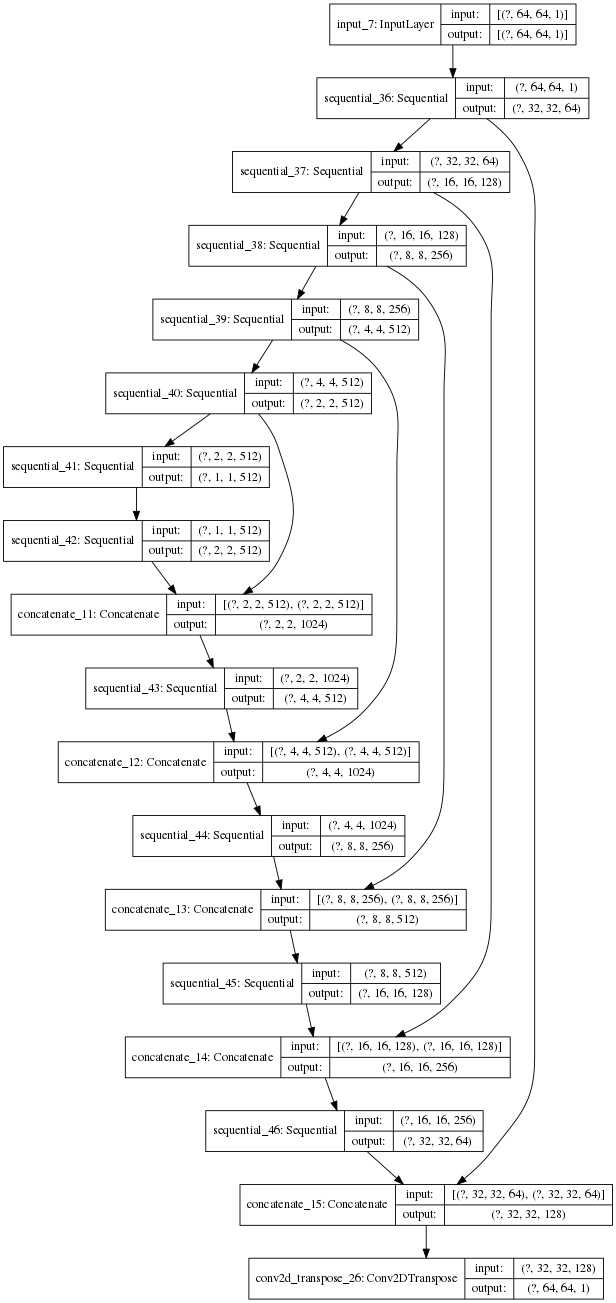

In [51]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

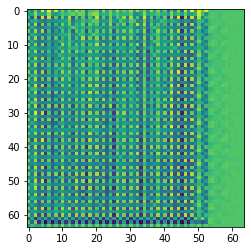

In [55]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,:, :, 0])

In [69]:
LAMBDA = 100

In [70]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Building the discriminator

In [72]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[64, 64, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[64, 64, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


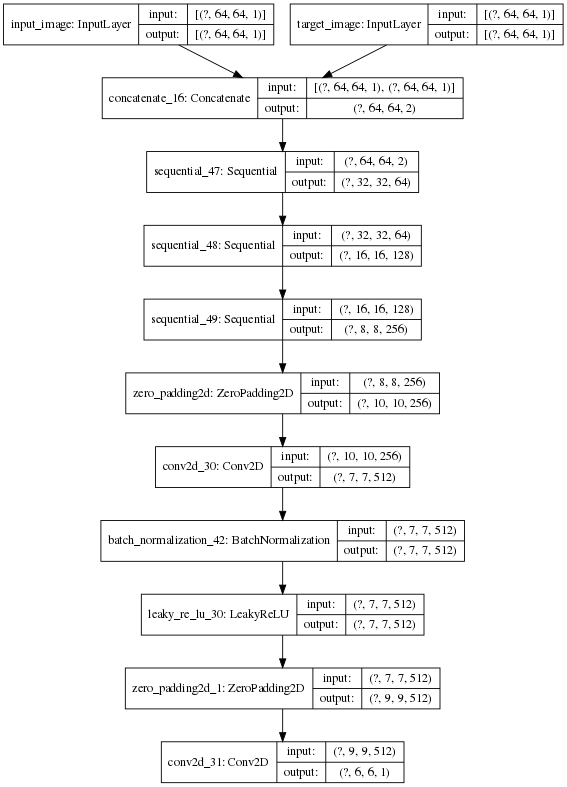

In [73]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

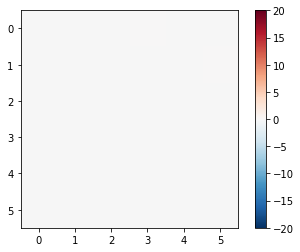

In [81]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,0], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [82]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [83]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [84]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [85]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [98]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [np.asarray(test_input[0, :, :, 0], dtype = np.float32), np.asarray(target[0, :, :, 0], dtype = np.float32), np.asarray(prediction[0, :, :, 0], dtype = np.float32)]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


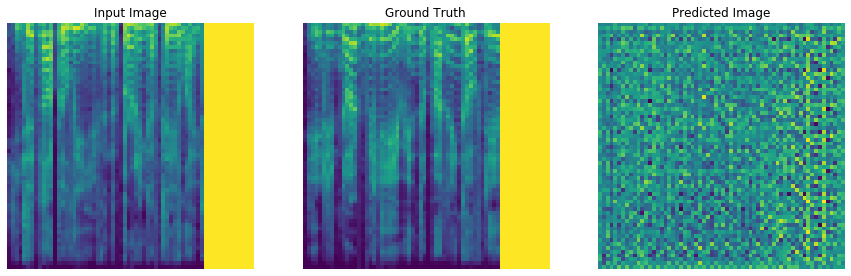

In [121]:
for example_input, example_target in test_dataset.take(1):
    example_input = tf.expand_dims(example_input, axis = 0)
    example_target = tf.expand_dims(example_target, axis = 0)
    generate_images(generator, example_input, example_target)


In [100]:
EPOCHS = 150

In [101]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [110]:
@tf.function
def train_step(input_image, target, epoch):
    input_image = tf.expand_dims(input_image, axis = 0)
    target = tf.expand_dims(target, axis = 0)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [125]:
def fit(train_ds, epochs, test_ds):
    for epoch in tqdm(range(1, epochs+1), ascii = True, unit = 'epochs'): 
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            example_input = tf.expand_dims(example_input, axis = 0)
            example_target = tf.expand_dims(example_target, axis = 0)
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)


In [126]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


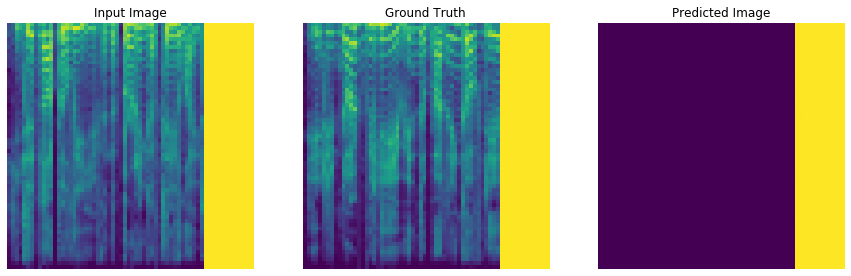

Epoch:  12
....................................................................................................
.

KeyboardInterrupt: 

In [130]:
fit(train_dataset, EPOCHS, test_dataset)